## Part 3 Loading Data & EDA

Import relevant packages for the following parts

In [297]:
import numpy as np
import pandas as pd
import math
import re
import sys
import seaborn as sns
sns.set()
sys.path.append('./')
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')

import nltk
from nltk.tokenize import word_tokenize

import gensim
import gensim.corpora as corpora
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

import pyLDAvis
import pyLDAvis.gensim

from preprocessing import get_processed_data


### Import data cleaned by using the selfwritten preprocessing module

In [193]:
keep_categories_all = ['Art & Design', 'Augmented Reality', 'Auto & Vehicles', 'Beauty', 'Books & Reference', 'Business', 'Comics', 'Communication', 'Dating', 'Daydream', 'Education', 'Entertainment', 'Events', 'Finance', 'Food & Drink', 'Health & Fitness', 'House & Home', 'Libraries & Demo', 'Lifestyle', 'Maps & Navigation']
apps_df, reviews_df = get_processed_data(path_to_apps='../Data.nosync/app_data_exam_09052020.csv', path_to_reviews='../Data.nosync/reviews_09052020.csv', keep_category=keep_categories_all)

loading files...
slice categories to "['Art & Design', 'Augmented Reality', 'Auto & Vehicles', 'Beauty', 'Books & Reference', 'Business', 'Comics', 'Communication', 'Dating', 'Daydream', 'Education', 'Entertainment', 'Events', 'Finance', 'Food & Drink', 'Health & Fitness', 'House & Home', 'Libraries & Demo', 'Lifestyle', 'Maps & Navigation']"...
preprocess metadata...
(1614, 7)
preprocess reviews...
I remove duplicates in apps_df and you in reviews_df deal?
Removing in apps_df...
Found 410 duplicates.
DONE!


Also delete duplicates in the apps' titles. 

In [194]:
apps_df.drop_duplicates(subset ="title", inplace = True) 

---

### EDA

In [196]:
apps_df.tail()

,app_id,title,genre,rating,comp_name,description,downloads,description_normalized
5828,01_60_0008,Kids Top Nursery Rhymes Videos - Offline Learning,Education,4.2,"Kidzooly - Kids Games, Rhymes , Nursery Songs.","All Nursery Rhymes, songs, offline videos are ...",9398.0,"[nursery, rhyme, song, offline, video, complet..."
5830,01_60_0010,tonies®,Entertainment,3.3,Boxine GmbH,Create your own audio adventures with the Toni...,521.0,"[create, audio, adventure, tonie, mobile, reco..."
5835,01_60_0015,Toon Goggles for TV,Entertainment,3.6,"Toon Goggles, Inc.","With Toon Goggles, your child can enjoy kid-sa...",79.0,"[toon, goggles, child, enjoy, safe, parent, ap..."
5843,01_60_0023,Animal sounds. Learn about animals and play.,Entertainment,4.6,Mihail Yakovlev,The application has more than 100 animals and ...,12939.0,"[application, animal, game, think, know, sound..."
5908,01_61_0056,Sago Mini Holiday Trucks and Diggers,Education,4.2,Sago Mini,Build a giant snow fort with trucks and digger...,8406.0,"[build, giant, snow, fort, truck, digger, pile..."


In [197]:
apps_df['genre'].unique()

array(['Art & Design', 'Maps & Navigation', 'Business', 'House & Home',
       'Education', 'Entertainment', 'Auto & Vehicles', 'Lifestyle',
       'Communication', 'Food & Drink', 'Beauty', 'Books & Reference',
       'Comics', 'Dating', 'Health & Fitness', 'Events', 'Finance',
       'Libraries & Demo'], dtype=object)

In [198]:
len(apps_df['genre'].unique())

18

In [199]:
apps_df.shape

(1203, 8)

Getting different information for _rating_

In [200]:
apps_df["rating"].value_counts()

4.5    155
4.3    148
4.6    140
4.4    123
4.2    107
4.1     96
4.7     81
4.0     72
3.9     48
3.8     48
3.7     39
4.8     37
3.5     24
3.6     20
4.9     12
3.2      7
3.3      7
2.9      7
2.6      5
5.0      5
3.4      4
3.1      4
2.2      3
2.8      3
2.3      3
2.7      2
2.0      2
2.4      1
Name: rating, dtype: int64

For the ratings, median and mean are relatively close together which indicates low outliers

In [201]:
round(apps_df["rating"].mean(),2)

4.24

In [202]:
apps_df["rating"].median()

4.3

Getting different information for _downloads_

For the downloads, the mean and median are far apart.Mean is more than 15 times as big as median. This indicates that there are many / strong outliers in the data. The maximum outlier is at 111Mio downloads which is almost 4000 times as much as the median value.

In [203]:
round(apps_df["downloads"].mean(),2)

464020.01

In [204]:
apps_df["downloads"].median()

28176.0

In [205]:
max(apps_df["downloads"])

111310275.0

Looking at the distribution _ratings_ & _downloads_

The indications resulting from comparing mean and median are also observable in the histograms of the data

In [206]:
def plot_hist(measure = 'rating'):
    print("Number of Unique {}: {}".format(measure, str(len(apps_df[measure].unique()))))
    print("{} Median: {}".format(measure, str(apps_df[measure].median())))
    print(apps_df[measure].describe())
    plt.figure(figsize=(14,4))
    plt.hist(apps_df[measure], bins = 100)
    plt.show()


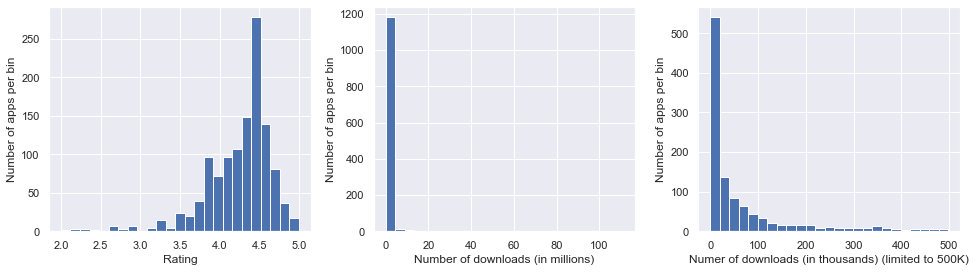

In [207]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].hist(apps_df["rating"], bins=25)
ax[0].set_xlabel("Rating")
ax[0].set_ylabel("Number of apps per bin")
ax[1].hist(apps_df["downloads"], bins=25)
xlabels = ['{:d}'.format(int(x)) for x in (ax[1].get_xticks()/1000000)*0.8]
ax[1].set_xticklabels(xlabels, ha="center")
ax[1].set_xlabel("Number of downloads (in millions)")
ax[1].set_ylabel("Number of apps per bin")
ax[2].hist(apps_df.downloads[apps_df["downloads"]<500000], bins=25)
xlabels = ['{:d}'.format(int(x)) for x in ax[2].get_xticks()/1000]
ax[2].set_xticklabels(xlabels)
ax[2].set_xlabel("Numer of downloads (in thousands) (limited to 500K)")
ax[2].set_ylabel("Number of apps per bin")
fig.tight_layout(pad=1.5)

 $\rightarrow$ Issue with outlier at 111 Mio downloads. This distorts the means and therefore the borders of sectors in downloads / rating space

### LDA

In [17]:
df_lda = apps_df.copy()

In [18]:
def part_of_speech(text):
    """
    Keeps only the tokens which as tagged as nouns
    """
    temp = nltk.pos_tag(text)
    return [word for word, tag in temp if 
            (tag == "NN") or 
            (tag == "NNS") or
            (tag == "NNP") or 
            (tag == "NNPS")]

In [19]:
df_lda["description_normalized"] = df_lda["description_normalized"].apply(part_of_speech)

In [20]:
df_lda.head()

,app_id,title,genre,rating,comp_name,description,downloads,description_normalized
0,01_01_0001,Glitter Beauty Coloring Book ❤,Art & Design,3.9,KiDEO (formerly forqan smart tech),"A very fun, educational and safe application f...",8769.0,"[application, game, manicure, dress, home, cle..."
1,01_01_0002,Poster Maker Flyer Maker 2020 free Ads Page De...,Art & Design,4.6,Splendid App Maker,Latest poster maker with new cool features hel...,68504.0,"[poster, maker, cool, feature, help, design, p..."
2,01_01_0003,How to make doll furniture,Art & Design,4.5,True Fun Apps,Do you love to play with your doll? It is wond...,11997.0,"[play, doll, idea, furniture, game, doll, ward..."
3,01_01_0004,"Art Camera -Cartoon,Pencil Sketch Art Effect P...",Art & Design,4.5,Model X Apps,Art Cartoon Camera is an artistic effect camer...,22755.0,"[cartoon, camera, effect, camera, apply, penci..."
4,01_01_0005,Over: Add Text to Photos & Graphic Design Maker,Art & Design,4.6,Over,Design and edit everything you need quickly an...,6953.0,"[design, edit, everything, template, font, too..."


Creating LDA dictionary to receive unique ID for each word

In [21]:
id2word = corpora.Dictionary(df_lda["description_normalized"])
print(len(id2word))

10557


Reducing the number of token by 

- removing words which occure in less than 10 documents
- words that occure at in more than 0.1 documents (fraction of total corpus size)

In [22]:
id2word.filter_extremes(no_below=10, no_above=0.1)
print(len(id2word))

corpus = [id2word.doc2bow(sent) for sent in df_lda["description_normalized"]]

1103


Getting the coherence scores for different number of topics

In [23]:
def coherence_plot(corpus=corpus, texts=df_lda["description_normalized"], dictionary=id2word, start = 15, stop=60):
    coherence_scores = [] 
    num_of_topics = []
    for i in range(start, stop+1):
        lda_model_temp = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i,
                                               alpha="auto",
                                               eta="auto",
                                               random_state=42)
        coherence_model_lda = CoherenceModel(model=lda_model_temp, texts=df_lda["description_normalized"], dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()
        num_of_topics.append(i)
        coherence_scores.append(coherence_score)
        
    plt.plot(num_of_topics, coherence_scores)
    plt.ylabel("Coherence Measure")
    plt.xlabel("Number of Topics")
    plt.show()  

Normally takes < than 500 seconds to execute below cell. 
Sometimes, it takes exceptionally long to run, so if it runs longer than 500 seconds, one should consider to try another machine to plot the coherence_plot.

In [ ]:
import time

t0 = time.time()

coherence_plot()

t1 = time.time()

total_time = t1-t0
print(total_time)

![coherence plot](coherence_plot.png)

The figure shows the coherence plot as it should be printed by running the code above. 

Setting up the based on the best coherence value model

In [298]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=54,
                                            alpha="auto",
                                            eta="auto",
                                            random_state=42)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [266]:
def top_word_vis(lda_model, num_topics, num_words, items_per_row):
    """
    Input:
    - lda_model: the LDA model to feed in
    - num_topics: number of topics to show
    - num_words: top n words to show in graph
    - items_per_row: how many topics to show in a row
    Output:
    - Graph with top n words of each topic
    """
    iters = len(lda_model.show_topics(num_topics=num_topics))
    fig, axs = plt.subplots(math.floor(iters/items_per_row)+1, items_per_row, figsize=(15,(math.floor(iters/items_per_row)+1)*3))
    for i in range(iters):
        temp  = [elem.split('*') for elem in lda_model.show_topics(num_words=num_words, num_topics=54)[i][1]
                 .replace('"', '').replace('+ ', '').split(" ")]
        nums = [float(i[0]) for i in temp]
        nums = nums[::-1]
        labels = [i[1] for i in temp]
        labels = labels[::-1]
        #plt.barh(y_pos, height)
        axs[math.floor(i/items_per_row)][i%items_per_row].barh(labels, nums)
        axs[math.floor(i/items_per_row)][i%items_per_row].set_title('Topic {}'.format(i))
    fig.tight_layout(pad=1.5)

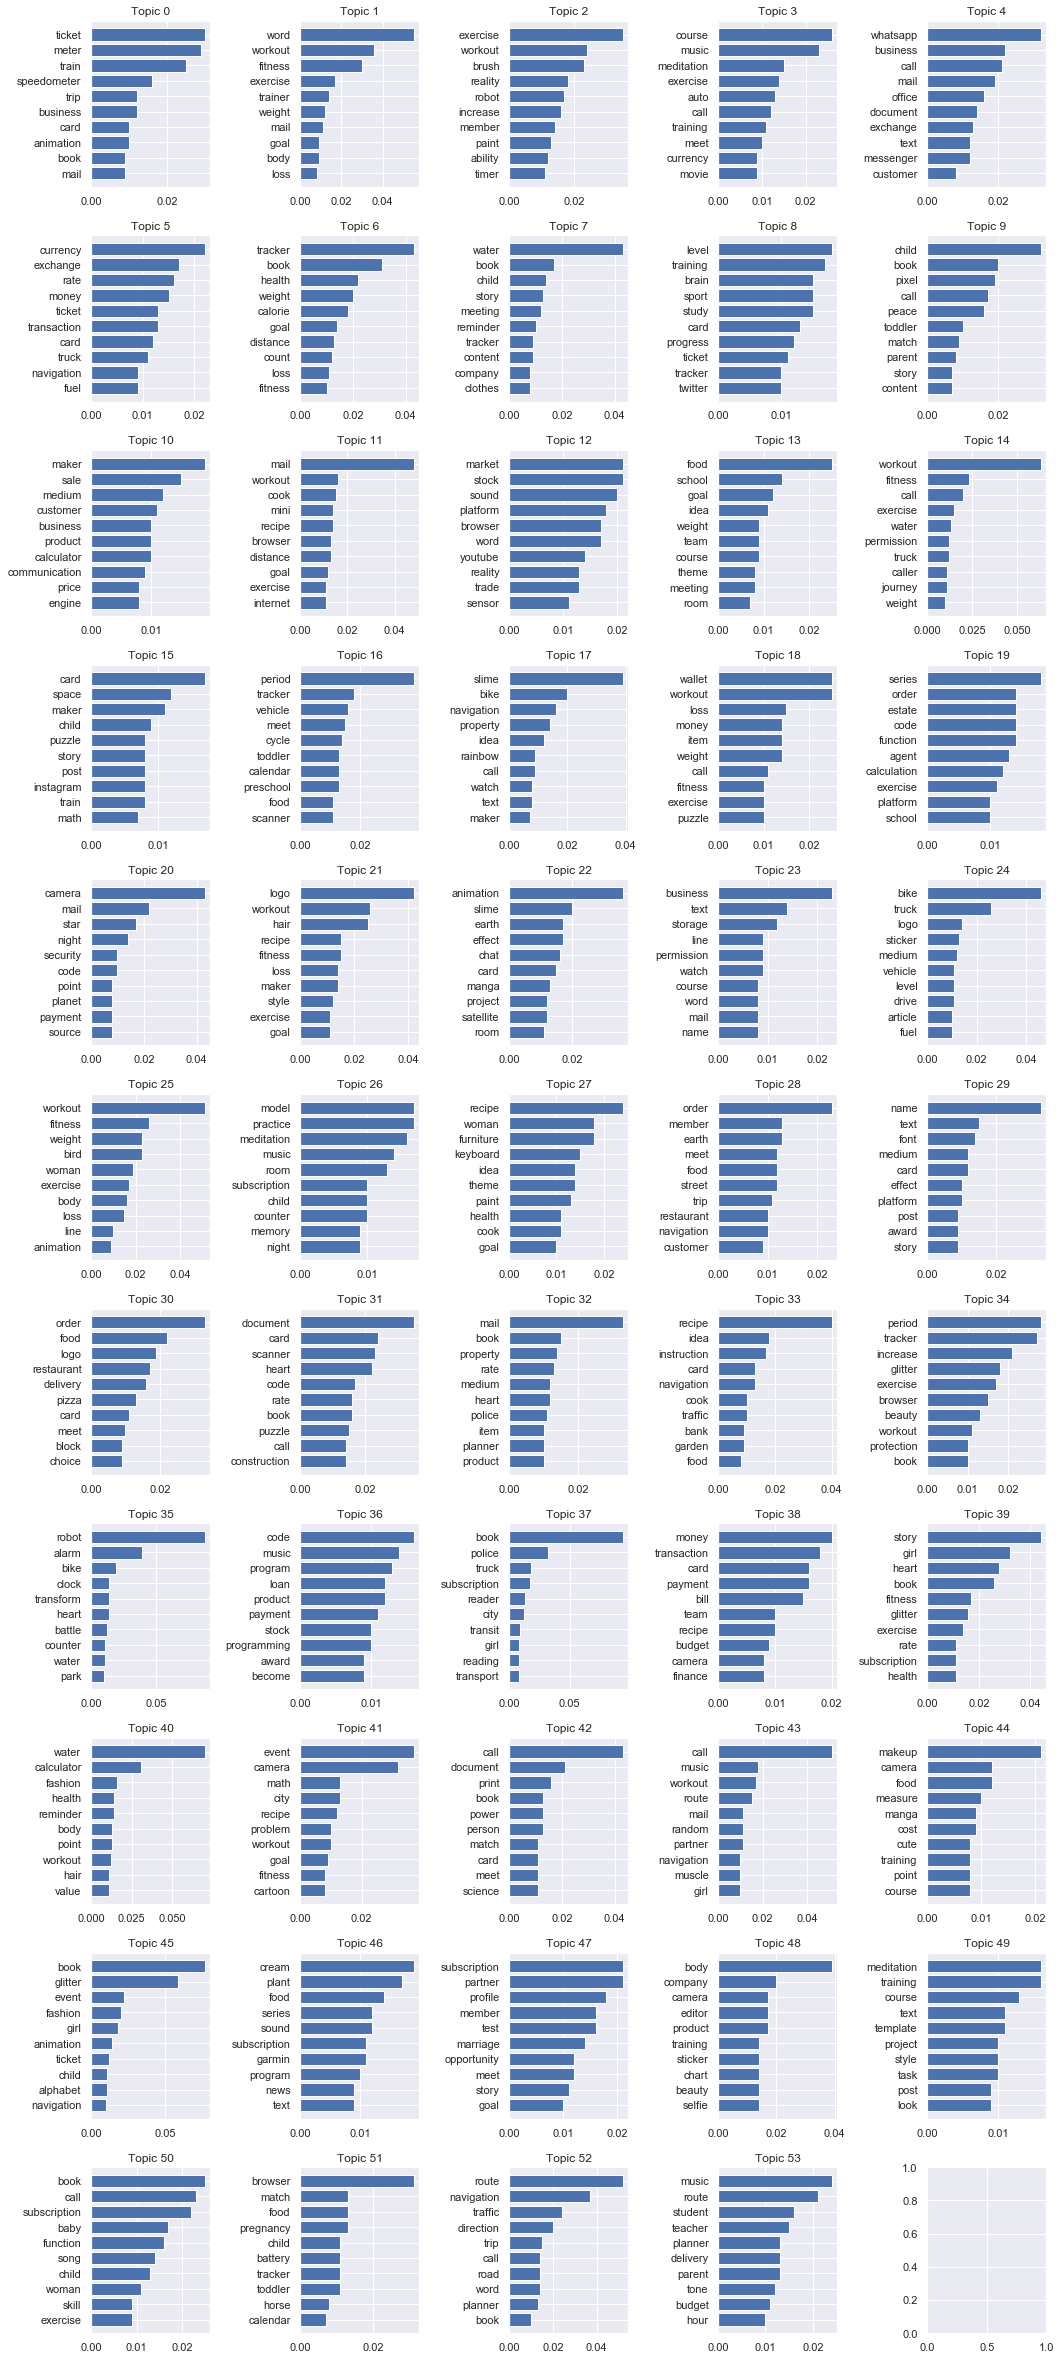

In [305]:
top_word_vis(lda_model, num_topics=54, num_words=10, items_per_row=5)

Date Document Topic Vectors in dataframe

In [299]:
df_doc2top = pd.DataFrame([[j[1] for j in i] for i in lda_model.get_document_topics(corpus, minimum_probability=0.0)])

In [300]:
df_doc2top.set_index(df_lda.index, inplace=True)

In [301]:
doc2top = df_doc2top.values

---

### Doc2Vec

In [271]:
df_doc2vec = apps_df.copy()

In [272]:
# tagging the documents
# building a doc2vec model, using small vector size and loc number of epochs
# to prevent the model from overfitting to the data

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_doc2vec["description_normalized"])]

model_apps = Doc2Vec(documents, vector_size = 30, min_count = 10,window = 10, dm_concat=False, dm_mean=True, epochs = 50, workers=8)


In [273]:
doc2vec = model_apps.docvecs.vectors_docs

### Transform data to two dimensional space using PCA
This is done to visualize the ideas behind the work because they would otherwise not be observable because of too high dimensionalities.

In [274]:
pca = PCA(n_components=2)

doc2vec_pca= pca.fit_transform(doc2vec)
doc2top_pca = pca.fit_transform(doc2top)


In [275]:
doc2vec_pca.shape

(1203, 2)

### Normalize the data
Data is normalized to disregard the document length. Otherwise long documents would not be clustered together with short documents although they are similar in content. 

The same effect is reached using the cosine distances but as KMeans does not work on cosine distance (as not implemented by sklearn) using the l2-distance on normalized data yields similar results and can be used as workaround.

In [302]:
doc2top_norm_pca = normalize(doc2top_pca, axis=1)
doc2top_norm = normalize(doc2top, axis=1)
doc2vec_norm_pca = normalize(doc2vec_pca, axis=1)
doc2vec_norm = normalize(doc2vec, axis=1)

In [277]:
np.sqrt(np.dot(doc2top_norm_pca[0,:], doc2top_norm_pca[0,:].T))

1.0

In [278]:
np.sqrt(np.dot(doc2top_norm[0,:], doc2top_norm[0,:].T))

1.0

In [279]:
np.sqrt(np.dot(doc2vec_norm_pca[0,:], doc2vec_norm_pca[0,:].T))

1.0

In [280]:
np.sqrt(np.dot(doc2vec_norm[0,:], doc2vec_norm[0,:].T))

1.0

### Optimize Amount of Clusters for K_Means
Using the inertias as well as silhouette scores. 

In [41]:
def kmean_test_n_clusters(data, n_clusters):
    """
    Takes the document vectors and the maximum amount of clusters to look for. 
    Performs KMeans algorithm on the dataset for each amount of clusters. 
    Calculates silhouette score and interias for each amount of clusters. 
    Plots the scores as a function of the amount of clusters.
    
    Arguments: 
    data -- document vectors as numpy matrices
    n_clusters -- integer that determines the maximum amount of clusters to test
    
    Returns: 
    Prints the scores as functions of the clusters in range 1, n_clusters
    """
    n_clusters += 1
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data)for k in range(1, n_clusters)]
    inertias = [model.inertia_ for model in kmeans_per_k]
    silhouette_scores = [silhouette_score(data, model.labels_)
                         for model in kmeans_per_k[1:]]

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 3.5))

    ax1.plot(range(1, n_clusters), inertias, "bo-")
    ax1.set_xlabel("$k$", fontsize=14)
    ax1.set_ylabel("Inertia", fontsize=14)
    #ax1.annotate('Elbow',
    #             xy=(4, inertias[3]),
    #             xytext=(0.55, 0.55),
    #             textcoords='figure fraction',
    #             fontsize=16,
    #             arrowprops=dict(facecolor='black', shrink=0.1)
    #            )
    ax2.plot(range(2, n_clusters), silhouette_scores, "bo-")
    ax2.set_xlabel("$k$", fontsize=14)
    ax2.set_ylabel("Silhouette score", fontsize=14)
    #plt.axis([2, 8, 0.3, 0.475])
    plt.show()

   

<IPython.core.display.Javascript object>


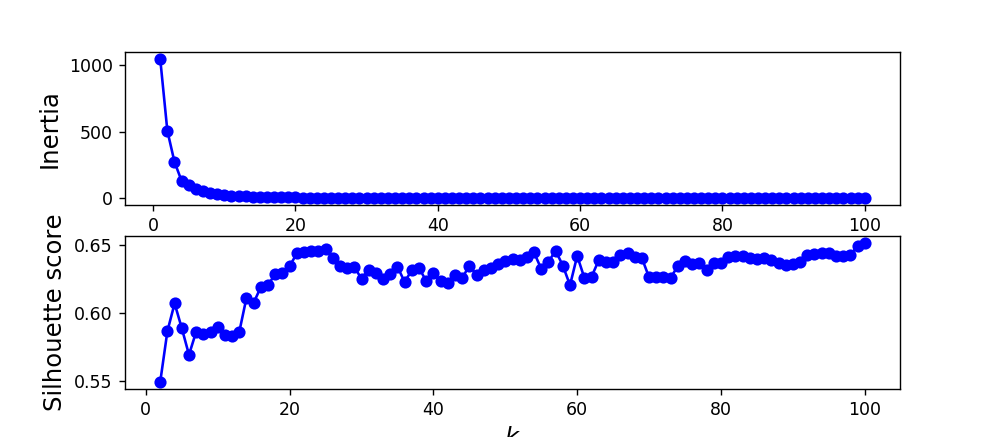

In [42]:
kmean_test_n_clusters(doc2top_norm_pca, 100)

<IPython.core.display.Javascript object>


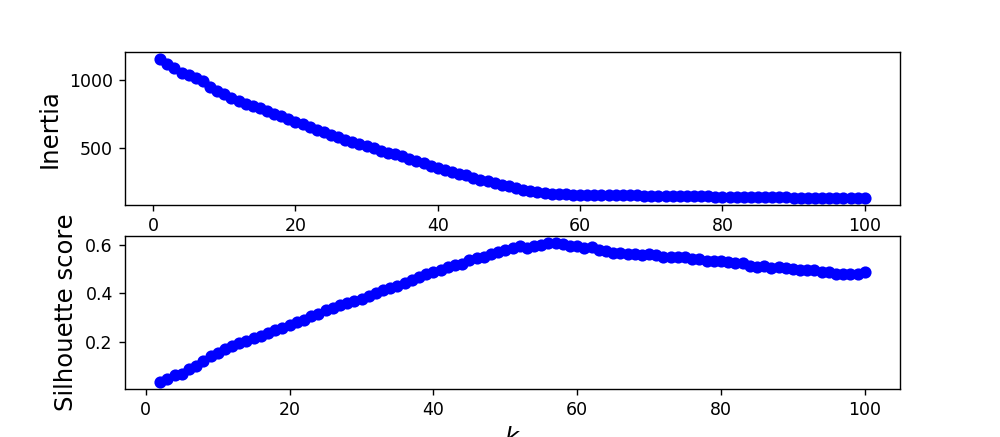

In [44]:
kmean_test_n_clusters(doc2top_norm, 100) # 54

<IPython.core.display.Javascript object>


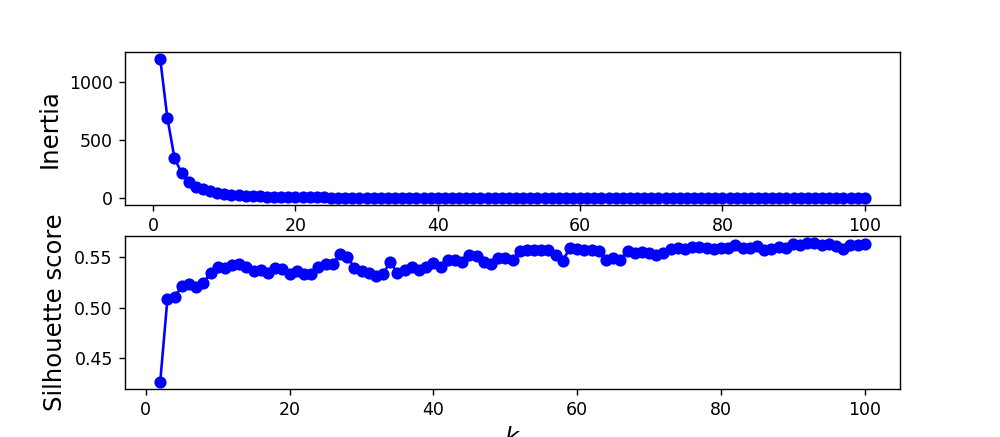

In [45]:
kmean_test_n_clusters(doc2vec_norm_pca, 100) #20, 42

<IPython.core.display.Javascript object>


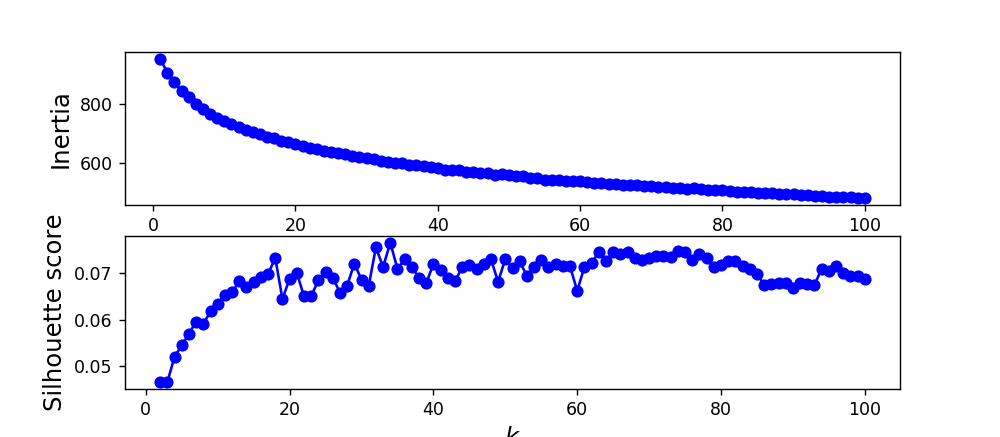

In [43]:
kmean_test_n_clusters(doc2vec_norm, 100)

##### Findings n_clusters for kmeans

- doc2top_pca: 14 or 60+ clusters
- doc2top: 54 clusters
- doc2vec_pca: 55 or 80+ clusters
- doc2vec: 33 clusters

### Optimize eps parameter for DBSCAN
Using a sorted list of the distances of each datapoint to its two nearest neighbors. 

In [46]:
def show_nn(X):
    """
    Calculates the average l2-distance between each vector and its two nearest neighbor. 
    Prints them found distances in sorted order. 
    This can be used to determine ehich eps value to take for the DBSCAN algorithm.
    """
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

<IPython.core.display.Javascript object>


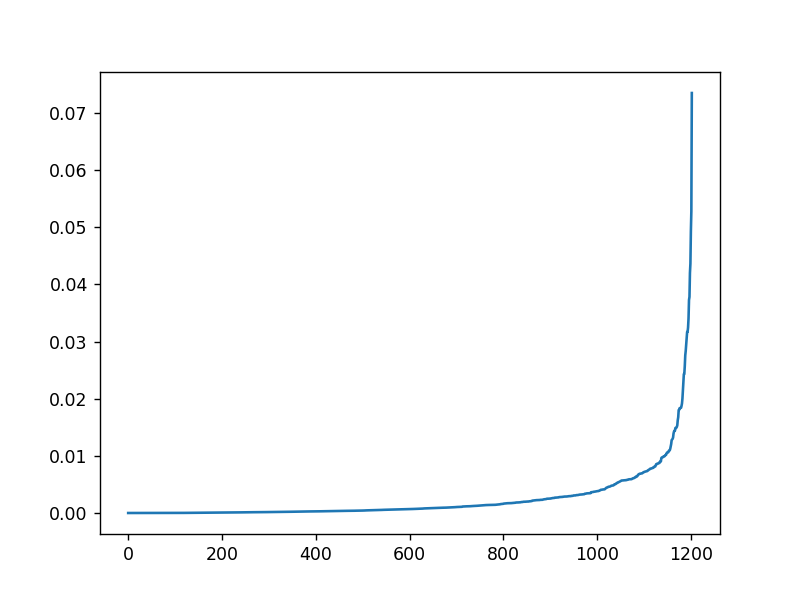

In [47]:
show_nn(doc2top_norm_pca) # 0.65

<IPython.core.display.Javascript object>


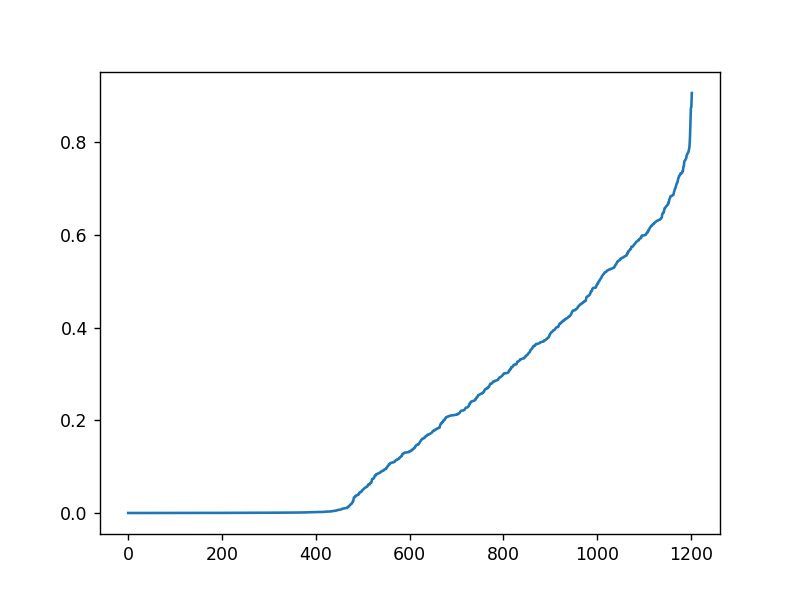

In [48]:
show_nn(doc2top_norm)

<IPython.core.display.Javascript object>


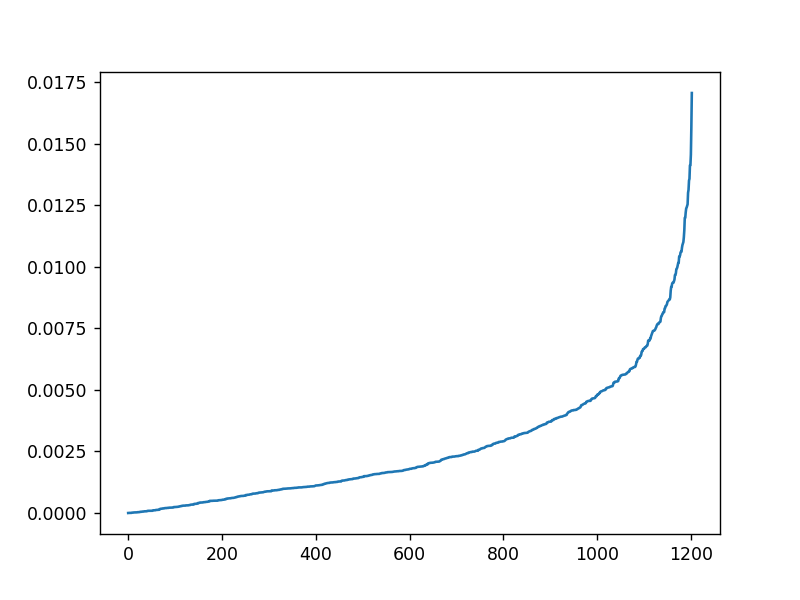

In [50]:
show_nn(doc2vec_norm_pca)

<IPython.core.display.Javascript object>


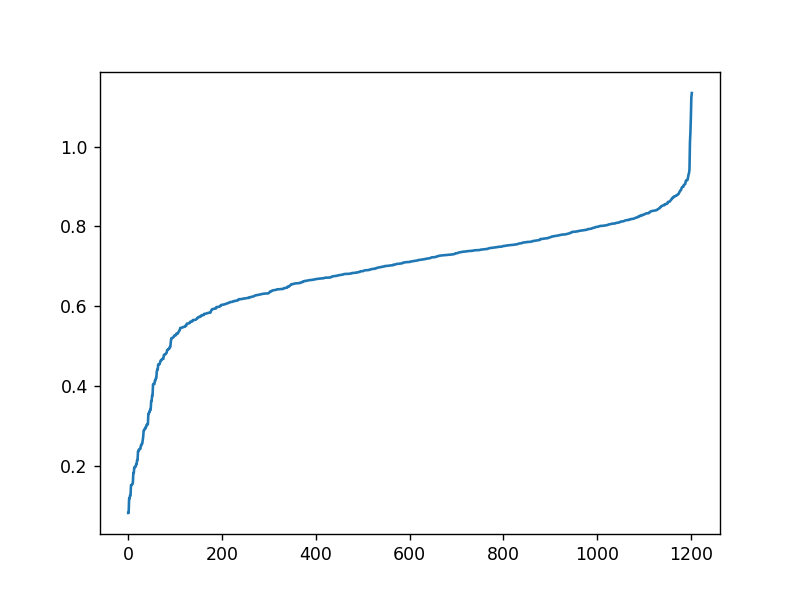

In [51]:
show_nn(doc2vec_norm)

### Cluster and Plot data (plotting only possible for pca_normalized data)

In [318]:
def cluster(X, algo = 'KMeans', pca = True, topics = False, min_samples=5, eps=0.1, n_clusters = 10, *args):
    
    if algo == 'KMeans':
        clu = KMeans(n_clusters = n_clusters, random_state = 1).fit(X)
    if algo == 'DBSCAN':
        clu = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    # obtain labels for the resulting clusters
    labels = clu.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    if pca: 
        algo += '_pca'
    if topics: 
        algo += '_topics'
    
    apps_df[str(algo)] = labels
    
    if pca: 
        plt.figure()
        #print(args[0])
        # plot the data, coloring points based on the cluster
        plt.scatter(X[:,0], X[:,1], c = labels, cmap = 'Set1', alpha = 0.4)
        try:
            for cat, (x,y) in zip(labels, args[0]):
                #plt.scatter(args[:,0],args[:,1])
                plt.text(x+0.1, y+0.1, cat)
        except IndexError:
                plt.title("{} clusters, {} noise".format(n_clusters_, n_noise_))
        #plt.xlabel(col1.name)
        #plt.ylabel(col2.name)
        plt.show()
    return n_clusters_, n_noise_


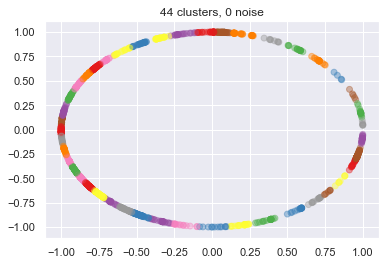

In [319]:
n_cluster_km_multi = cluster(doc2top_norm_pca, 'KMeans', pca = True, topics = True, n_clusters=44)

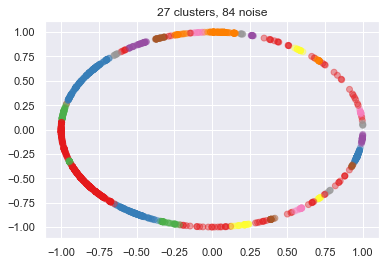

27 84


In [320]:
n_cluster_DB_topics, n_noise = cluster(doc2top_norm_pca, 'DBSCAN', pca = True, topics = True, eps=0.025)
print(n_cluster_DB_topics, n_noise)

In [321]:
n_cluster_doc2top_norm_km, n_noise = cluster(doc2top_norm,
                             'KMeans', 
                             pca = False, 
                             topics = True, 
                             n_clusters=54)

In [322]:
n_cluster_doc2top_norm_db, n_noise = cluster(doc2top_norm, 
                                             'DBSCAN', 
                                             pca = False, 
                                             topics = True, 
                                             eps=0.64)
print(n_cluster_doc2top_norm_db, n_noise)

39 88


In [323]:
n_cluster_doc2vec_norm_km, n_noise = cluster(doc2vec_norm, 
                                    'KMeans', 
                                    pca = False, 
                                    topics = False, 
                                    n_clusters=33)

In [324]:
n_cluster_doc2vec_norm_db, n_noise = cluster(doc2vec_norm, 
                                             'DBSCAN', 
                                             pca = False, 
                                             topics = False, 
                                             min_samples=3,
                                             eps=0.773)
print(n_cluster_doc2vec_norm_db, n_noise)

18 367


The DBSCAN algorithm defines clusters by the density of points in a region in space. This is why the algorithm is also able to detect outliers. These outliers are further away from dense areas and therefore not assigned to any cluster. 

In the case of applying the DBSCAN on the Doc2Vec data however, the DBSCAN is hardly applicale. This is due to the tradeoff between the amount of clusters and the amount of outliers. To perform a granular analysis, it is aimed for finding more clusters than genres used from Google Playstore (clusters > 18). But also nust the anount of outliers be low because otherwise many applications are not considered in the analysis, which leads to a inaccurate description of the market in the model (outliers < 10% == outliers < 120).

Regarding the described tradeoff, we achieved the best results with a minimum cluster size of 3 clusters and an eps of 0.773. This setting resulted in 21 clusters and 355 (29.5%) outliers found. Setting the mimimumn number of apps per cluster lower would result in less outliers but grouping two apps together does not add any value to the analysis. Adjusting the parameter from the found value results in either lower clusters than genres used from Google Playstore or even more outliers. Thus, it was decided to not use DBSCAN for further analysis and concentrate on KMeans since is assigns each observation to a cluster.

---

In [325]:
apps_df[apps_df['DBSCAN'] > 0]['downloads'].mean()

1007653.3571428572

In [326]:
apps_df[apps_df['DBSCAN'] == 1]['downloads'].mean()

16814.0

In [327]:
def plot_cluster_rd_space(n_cluster, algo = 'KMeans', pca = True):
    """
    Plotting the clusters as single data points in the two dimensional 
    downloads / ratings space. The cluster is represented by the mean rating and 
    log transformed mean number of downloads of the apps contained. The dashed lines
    represent the mean rating and the log transformed mean number of downloads of
    the total apps of all clusters. 
    
    Arguments: 
    n_clusters -- the amount of clusters for each dataset
    algo -- the algorithm that is used for clustering
    pca -- boolean whether the data was pca transformed or not
    
    Results: 
    Prints the clusters and the total averages. 
    """
    df = apps_df.copy()
        
    
    # optionally set downloads to log. Does not change much though.
    #df = df[df['downloads'] <= 2000000]
    mean_rating = df['rating'].mean()
    mean_downloads = math.log(df[df[algo] >= 0]['downloads'].mean())
    cluster_ratings = [df[df[str(algo)] == i]['rating'].mean() for i in range(n_cluster)]
    cluster_downloads = [math.log(df[df[algo] == i]['downloads'].mean()) for i in range(n_cluster)]
    
    font = {'size'   : 16}
    plt.rc('font', **font)
    sns.set_style("whitegrid")
    plt.figure(figsize=(8,8))
    plt.scatter(cluster_downloads, cluster_ratings, marker = '.', color = 'black', s=150)
    plt.xlim(min(cluster_downloads), max(cluster_downloads))
    plt.ylim(min(cluster_ratings)-0.01,max(cluster_ratings)+0.01)
    plt.axvline(x=mean_downloads, ymin=0, ymax=max(cluster_ratings), linestyle = '--')
    plt.axhline(y=mean_rating, xmin=0, xmax=max(cluster_downloads), linestyle = '--')
    plt.xlabel('avg. downloads (log scale)', fontsize=16)
    plt.ylabel('avg. ratings', fontsize=16)
    for i in range(n_cluster):
        plt.annotate(str(i), 
                     (cluster_downloads[i],cluster_ratings[i]))
    plt.axhspan(ymin=min(cluster_ratings)-0.01, ymax=mean_rating, facecolor='c', alpha=0.5)
    plt.axhspan(mean_rating, max(cluster_ratings)+0.01, facecolor='r', alpha=0.5)
    plt.axvspan(min(cluster_downloads), mean_downloads, facecolor='grey', alpha=0.3)
    plt.axvspan(mean_downloads, max(cluster_downloads), facecolor='w', alpha=0.5)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
    #if pca: 
    #    plt.title('{} PCA Clusters in Download / Rating Space'.format(algo))
    #else: 
    #    plt.title('{} NON_PCA Clusters in Download / Rating Space'.format(algo))

    plt.show()

In [328]:
apps_df.columns

Index(['app_id', 'title', 'genre', 'rating', 'comp_name', 'description',
       'downloads', 'description_normalized', 'KMeans_pca_topics',
       'DBSCAN_pca_topics', 'KMeans_topics', 'DBSCAN_topics', 'KMeans',
       'DBSCAN'],
      dtype='object')

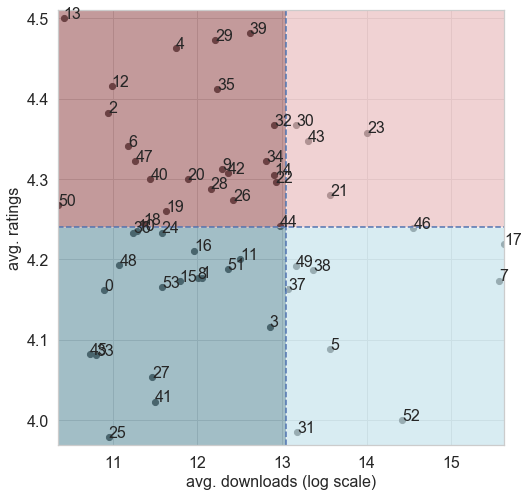

In [329]:
plot_cluster_rd_space(n_cluster_doc2top_norm_km, 
                      algo = 'KMeans_topics', 
                      pca=False)

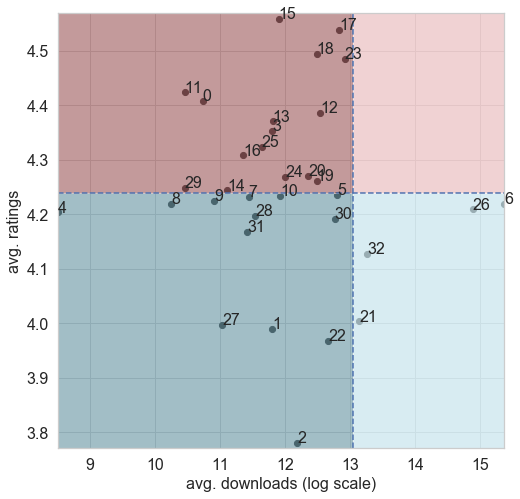

In [330]:
plot_cluster_rd_space(n_cluster_doc2vec_norm_km, 
                      algo = 'KMeans', 
                      pca=False)

### Printing information about the clusters of the respective clusters

In [294]:
def print_cluster_summary(algo, i):
    """
    Printing a small summary of the apps of a cluster. 
    
    Arguments: 
    algo -- the algorithm that was used for clustering (KMeans_topic or KMeans)
    i -- the label number of the target cluster
    
    Returns: 
    A printout containing : 
    -- the cluster label 
    -- the number of apps within the cluster
    -- the titles of the apps in the cluster 
    """
    assert algo in ['DBSCAN', 'KMeans', 'DBSCAN_topics', 'KMeans_topics']
    
    cluster_df = apps_df.copy()
    cluster_df = cluster_df[cluster_df[algo] ==  i]
    print('Cluster {} consists out of {} apps.'.format(str(i), str(cluster_df.shape[0])))
    titles = list(cluster_df['title'])
    print('The apps are:\n {}'.format('\n\t'.join(titles)))

In [368]:
print_cluster_summary('KMeans', 2)

Cluster 2 consists out of 41 apps.
The apps are:
 Zoosk: Date, Connect & Find Your Best Match
	Galaxy - Chat Rooms: Meet New People Online & Date
	BLOOM — Premium Dating & Find Real Love
	muzmatch: Muslim & Arab Singles, Marriage & Dating
	Mingle2 - Free Online Dating & Singles Chat Rooms
	Just She - Top Lesbian Dating
	Coffee Meets Bagel Free Dating App
	Hitwe - meet people and chat
	Dating.com: meet new people
	Muslima - Muslim Matrimonials App
	InMessage - Chat Meet Dating
	DateMyAge: Dating for mature singles
	Wapa: Lesbian Dating
	Parship – dating
	YoCutie - 100% Free Dating App
	Transdr - #1 Transgender & Crossdresser Dating App
	SeekingArrangement
	Hawaya - Serious Dating App with Marriage in Mind!
	AmoLatina: Find & Chat with Singles - Flirt Today
	Lovetastic - Find your perfect date
	ArabianDate: Chat&Date online
	YourChristianDate: Meet Your Christian Soul Mate
	3Fun - Curious Couples & Singles Dating App
	Hily – Meet New People, Make Friends & Find Dates
	Soudfa - تعارف دردش

---

# Code Backlog

The code is adapted from Doc2Vec documentation, here we can propose a description and see the most similar descriptions from other apps to the one of ours, thanks to that, we can assign a new description to one of the clusters given by K-Means - can this have some implications for the creators of the apps? Can they willingly try to alter descriptions in order to be assigned to different categories (clusters)?

In [351]:
#add tagged documents in a list
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(apps_df["description_normalized"])]


In [352]:
#initialize the model

model_apps = Doc2Vec(vector_size = 30, min_count = 5, window = 7, 
                     epochs = 25, dm_concat=True, dm_mean=True, workers=8,seed = 10)
#use vocabulary of documents and train the model
model_apps.build_vocab(documents)

#train the model
print("training the model...")
model_apps.train(documents, total_examples=model_apps.corpus_count, epochs=model_apps.epochs)

print("done")

training the model...
done


In [353]:
doc_vecs = model_apps.docvecs.vectors_docs

#reduce dimensionality to 2 for visualization
print("reducing the dimensions...")
pca = PCA(n_components=2)
datapoint = pca.fit_transform(doc_vecs)
print("done")

reducing the dimensions...
done


In [354]:
def k_means_cluster(datapoint, *args, n_clusters = 54):
    """    
    takes the list with dimensions of app descriptions' datapoints 
    optional argument args is for new points in case we would like to plot in which clusters the new descriptions would be 
    placed
    also gives an option to edit the amount of clusters
    
    outputs the plot with clusters
    """

    # run k-means
    km = KMeans(n_clusters = n_clusters, random_state = 1)
    # fit the data to the k-means model
    km.fit(datapoint)
    # obtain labels for the resulting clusters
    labels = km.labels_
    plt.figure(figsize=(9,5))
    # plot the data, coloring points based on the cluster
    #for label in np.unique(labels):
        #plt.scatter(datapoint[labels==label,0],  datapoint[labels==label,1],c=label,label=label)
    plt.set_cmap('Set2')
    
    plt.scatter(datapoint[:,0], datapoint[:,1], label = labels, c = labels) 
    try:
        plt.scatter(args[0][:,0],args[0][:,1],c="red")
        plt.legend()
        """ for cat, (x,y) in zip(labels, args[0]):
            #plt.scatter(args[0][:,0],args[0][:,1],c=colors[cat])
            plt.text(x+0.1, y+0.1, cat)"""
    except IndexError:
            plt.title("K-means, {} clusters".format(n_clusters))
    plt.legend(loc = "lower right")
    plt.show()

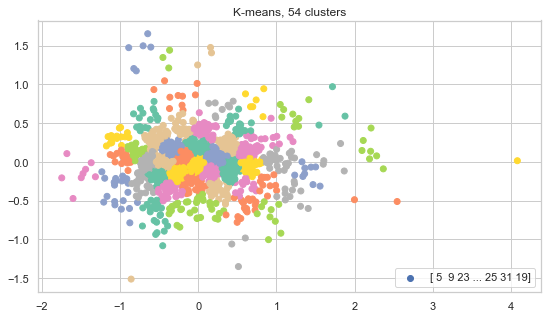

In [355]:
#cluster the apps 
k_means_cluster(datapoint)

The code is adapted from Doc2Vec documentation, here we can propose a description and see the most similar descriptions from other apps to the one of ours, thanks to that, we can assign a new description to one of the clusters given by K-Means - can this have some implications for the creators of the apps? Can they willingly try to alter descriptions in order to be assigned to different categories (clusters)?

In [357]:
#test similarity of a random document from the training corpus

#generate random number
doc_id = np.random.randint(0, len(documents) - 1)


#infer new vector of the selected document and calculate similarities with all others
inferred_vector=model_apps.infer_vector(documents[doc_id].words)
sims = model_apps.docvecs.most_similar([inferred_vector], topn=len(model_apps.docvecs))

# Compare and print the most, second most and least similar document
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(documents[doc_id].words)))
#most similar should be the same document - to assess the performance
for label, index in [('Most similar: \n', 1), ('Second most: \n',2),('Third most: \n', 3), ('Least similar: \n', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(documents[sims[index][0]].words)))

Test Document (1024): «berlin subway official bahn bahn includes helpful route planner whether visiting berlin first time need help getting live locally want check time next train berlin subway ultimate navigation feature official berlin bahn underground bahn urban rail easy search station find closest location anywhere berlin using route planner simply enter start point rest time train departure board plan route point interest reichstag building alexanderplatz checkpoint charlie information route long journey take many station many change need make step step guide route available make sure take wrong turn star favourite route store quick access thinking visiting hamburg munich make sure check hamburg metro route planner munich metro route planner apps google play need information question berlin subway join facebook mapwayapps follow twitter mapwayapps berlin subway number permission visit mapway privacy policy»

Most similar: 
 (782, 0.5203031301498413): «best coloring book therapy a

In [358]:
#test corpus consisting of texts from websites describing apps and parts of actual documents to test if they are similar to their full texts
test_corpus = [["Trying to lose weight, gain muscle, exercise more consistently, or push yourself to higher intensity workouts? Listen, everyone needs a little help when it comes to getting fit. Fitness apps give you that help by reminding you of your goals and prompting you to follow through on them. They also provide the tools and information you need, whether it's a calorie calculator or a trainer who plans your workouts and coaches you along. A few nudges in the right direction from a couple of great apps might make all the difference."],
               ["signal garden research atom visualizer enables explore atomic model augmented reality google arcore please note atom visualizer requires google arcore compatible android device arcore supported device atom visualizer brings science home classroom everything around made atom visualizer valuable pedagogical tool help begin answering question simple enough used even kindergarten many understand basic structure atom nucleus containing proton neutron surrounded electron electron organized move look like scientist science teacher common model answer question visualize atom bohr model present atom nucleus orbiting electron help understand energy level electron organized relation nucleus quantum mechanical model present atom electron cloud help understand possible location electron relation nucleus atom visualizer augmented reality create animated visualization model real world using camera launching start camera plus button choose element periodic table create animated atomic model place atom wherever want real space view screen adjust animation speed slider switch animated visualization atom bohr model nucleus orbiting electron quantum mechanical model complete random animated electron cloud learn element wikipedia link step signal garden atom visualizer designed built eight week jonathan barndt using electrolyte engine national science foundation step internship signal garden part stem talent expansion program jonathan mentored signal garden dylan hart lead engineer signal mapper google tango omar shaikh lead engineer solar simulator google tango jonathan study computer science university mexico program advisor professor cassiano oliveira program coordinator kelly cockrell project supervisor dylan hart project coordinator omar shaikh project administrator james croney produced chuck knowledge powered electrolyte engine signal garden research corporation right reserved"],
               ["helps you identify plants and animals around you get connected with a community of over scientists and naturalists who can help you learn more about nature by recording and sharing your observations create research quality data for scientists working to better understand and protect nature  Receive suggestions and crowdsourced identifications of what you've seen â€˘ Discuss and help others identify what they've seenâ€˘ Follow projects comprised of smaller communities and fellow citizen scientists passionate about a particular place"],
               ["Edmodo gives teachers the tools to share engaging lessons, keep parents updated, and build a vibrant classroom community.The all-new Edmodo app has been redesigned from the ground up to focus on how YOU communicate with your students, parents, and fellow teachers.TOOLS THAT TEACHERS NEEDA home stream for following and discovering resources from teachers across the globe.All your classes and assignments organized in one place.Send messages directly to students and parents"],
               ["Text messaging is among the most popular ways to communicate in the whole world. It’s quick, easy to do, and it doesn’t require you pausing what you’re doing like phone calls do. We do understand that many people still prefer the human touch of talking on the phone and we respect that. However, let’s face facts, most people are texting these days. Let’s take a look at the best texting apps and SMS apps for Android to see if we can’t help you make your texting experience better. Do note that various texting apps will have issues depending on your device, Android version, carrier, and texting habits. That’s why we list ten of them!"],
               ["It can be hard to keep kids occupied sometimes, especially when school is out. That's why you typically reach for tablets, phones, or other electronic devices for your kids to play with when they're bored. But it can be difficult to figure out which apps are worth downloading (and even buying) — let alone deciding which ones are safe and kid-friendly.That's why the Good Housekeeping Institute tested a bunch of apps on the market and consulted our consumer panel (made up of real parents and their children!) in order to find the best ones to download. Whether your kid is in pre-school or high school, there are fun, educational, and even some free apps on this list for them, no matter what they're interested in. Grab your charger (or portable battery) and download the best apps for kids in 2019"],
               ["Problem solver. Communicator. Financial whiz. Running a small business involves wearing a lot of hats. If you’re looking to increase productivity and organization — or just make your life as an entrepreneur a little easier — a good business app might be just what you need. To help you navigate the seemingly endless sea of business apps, we’ve compiled a list of our favorite 25 apps and broken them down by category. Check with the individual companies for current pricing information."]
              ]

In [359]:
#function that infers vectors out of strings in a list
def infer_vec(text):
    #split text into tokens
    split_text = []
    for i in text:
        split_text.append(i[0].split())
        
    #save lists of tokens as series
    split_text = pd.Series(split_text)    
    
    #create tagged documents out of the series
    new_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(split_text)]

    #infer vectors and save in a list
    inferred_vectors = []
    for doc_id in range(len(new_docs)):
        inferred_vector = model_apps.infer_vector(new_docs[doc_id].words)
        inferred_vectors.append(inferred_vector)

    return inferred_vectors

In [361]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = np.random.randint(0, len(test_corpus) - 1)

#infer vectors from the test descriptions, save similarities of all documents with the vector of random doc_id
vect=infer_vec(test_corpus)
sims = model_apps.docvecs.most_similar([vect[doc_id]], topn=len(model_apps.docvecs))
    
# Compare and print the most, second most and least similar document

print("printing the model with parameters: vector_size = %s, window = %s, min_count = %s, epochs = %s, \n dm_concat = %s" % (model_apps.vector_size, model_apps.window, model_apps.vocabulary.min_count,model_apps.epochs,model_apps.dm_concat))
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
for label, index in [('Most similar: \n', 0), ('Second most: \n',1),('Third most: \n', 2), ('Least similar: \n', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(documents[sims[index][0]].words)))

printing the model with parameters: vector_size = 30, window = 7, min_count = 5, epochs = 25, 
 dm_concat = 1
Test Document (2): «helps you identify plants and animals around you get connected with a community of over scientists and naturalists who can help you learn more about nature by recording and sharing your observations create research quality data for scientists working to better understand and protect nature  Receive suggestions and crowdsourced identifications of what you've seen â€˘ Discuss and help others identify what they've seenâ€˘ Follow projects comprised of smaller communities and fellow citizen scientists passionate about a particular place»

Most similar: 
 (286, 0.6405449509620667): «challenger comic viewer free advanced comic manga book viewer really simple scroll page automatically loaded displayed need click next page free version work perfectly phone tablet supported image file format webp android supported book file format djvu epub main feature automatic page

In [362]:
def assess_new_description(text):
    """
    accepts a new descriptions in a list, appends it to the existing dataset and places it into cluster map
    """
    #infer vectors of the list of new descriptions
    text_vectors = infer_vec(text)
    text_vectors = pca.fit_transform(text_vectors)
    array_vectors = np.array(text_vectors)
    #print(array_vectors)

    new_datapoint = np.concatenate((datapoint,array_vectors),axis = 0)
    #print(len(datapoint))
    #print(len(new_datapoint))
    k_means_cluster(datapoint,array_vectors)
    #k_means_cluster(new_datapoint)

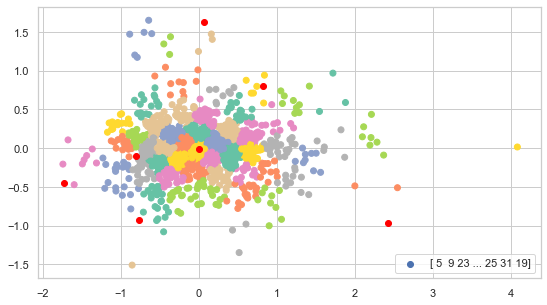

In [363]:
assess_new_description(test_corpus)

---

#### Display PCA scatter plot for words in a trained word2vec model

In [366]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

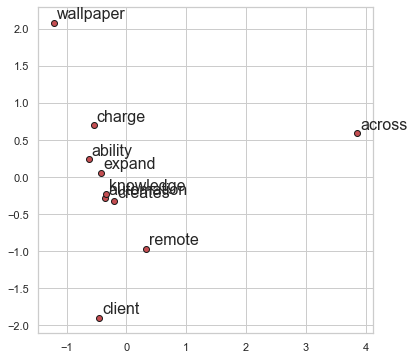

In [367]:
display_pca_scatterplot(model_apps, sample=10)